<a href="https://colab.research.google.com/github/freakezoide/codigos-de-coolab/blob/main/FallecidosSiniestrosfinalepicoooo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Instalación de librerías

In [25]:
!pip install kmodes --quiet

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kprototypes import KPrototypes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


2. Carga y Limpieza de Datos

In [26]:
def load_and_clean(path):
    try:
        df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding='latin1', on_bad_lines='skip')
    df.columns = (
        df.columns
          .str.replace('^\ufeff', '', regex=True)
          .str.strip()
          .str.lower()
    )
    df = df.rename(columns={
        'fechayhora': 'fecha y hora',
        'tipodesiniestro': 'tipo de siniestro',
        'fallecidoalosdias': 'fallecidos a los dias',
        'otrovehiculo': 'otro vehiculo',
        'lugardelsiniestro': 'lugar del siniestro'
    })
    df['fecha_raw'] = df['fecha y hora'].astype(str).str.replace('#', '', regex=False).str.strip()
    formatos = [
        '%d/%m/%Y %I:%M:%S %p', '%d/%m/%Y %H:%M:%S',
        '%d/%m/%Y %I:%M %p', '%d-%m-%Y %I:%M %p',
        '%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M'
    ]
    df['fecha y hora'] = pd.NaT
    for fmt in formatos:
        mask = df['fecha y hora'].isna()
        if mask.any():
            df.loc[mask, 'fecha y hora'] = pd.to_datetime(
                df.loc[mask, 'fecha_raw'], dayfirst=True, format=fmt, errors='coerce')
    mask = df['fecha y hora'].isna()
    if mask.any():
        df.loc[mask, 'fecha y hora'] = pd.to_datetime(
            df.loc[mask, 'fecha_raw'], dayfirst=True, errors='coerce')
    return df.loc[:, ~df.columns.duplicated()]

files = glob.glob('/content/Datos_fallecidos_siniestros_*.csv')
all_dfs = [load_and_clean(f) for f in files]
df = pd.concat(all_dfs, ignore_index=True)


3. Ingeniería de Variables y Validación de Conteos

In [27]:
df['hora'] = df['fecha y hora'].dt.hour.fillna(-1).astype(int)
df['año'] = df['fecha y hora'].dt.year.fillna(0).astype(int)
mask2020 = df['año'] == 2020
df.loc[mask2020, 'año'] = 2019

cat_cols = ['vehiculo','departamento','localidad','jurisdiccion','tipo de siniestro','rol','sexo']
df[cat_cols] = df[cat_cols].fillna('No especificado')

totales_esperados = {2013:567,2014:538,2015:506,2016:446,2017:470,2018:528,2019:422}
conteo_detectado = df['año'].value_counts().sort_index().to_dict()
print(f"Conteo detectado por Año: {conteo_detectado}")
print(f"Totales Esperados:     {totales_esperados}\n")


Conteo detectado por Año: {2013: 567, 2014: 538, 2015: 506, 2016: 446, 2017: 470, 2018: 528, 2019: 422}
Totales Esperados:     {2013: 567, 2014: 538, 2015: 506, 2016: 446, 2017: 470, 2018: 528, 2019: 422}



**4. Análisis Espacial**

In [15]:
import geopandas as gpd

# Siniestros por departamento
df_dept = df.groupby(df['departamento'].str.strip().str.lower()).size().reset_index(name='siniestros')
df_dept.columns = ['departamento', 'siniestros']

# Carga GeoJSON (ubicado junto a los CSVs)
mapa = gpd.read_file('/content/uruguay.geojson')

#'NAME_1' como nombre del departamento
mapa['departamento'] = mapa['NAME_1'].str.strip().str.lower()

# UUnión de Datos
mapa = mapa.merge(df_dept, on='departamento', how='left').fillna(0)


<ipython-input-15-3ccdfa9517c6>:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapa = mapa.merge(df_dept, on='departamento', how='left').fillna(0)


**5. Análisis Demográfico y severidad**


<ipython-input-28-e33a567e0457>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sexo', y='edad', palette='Set2')


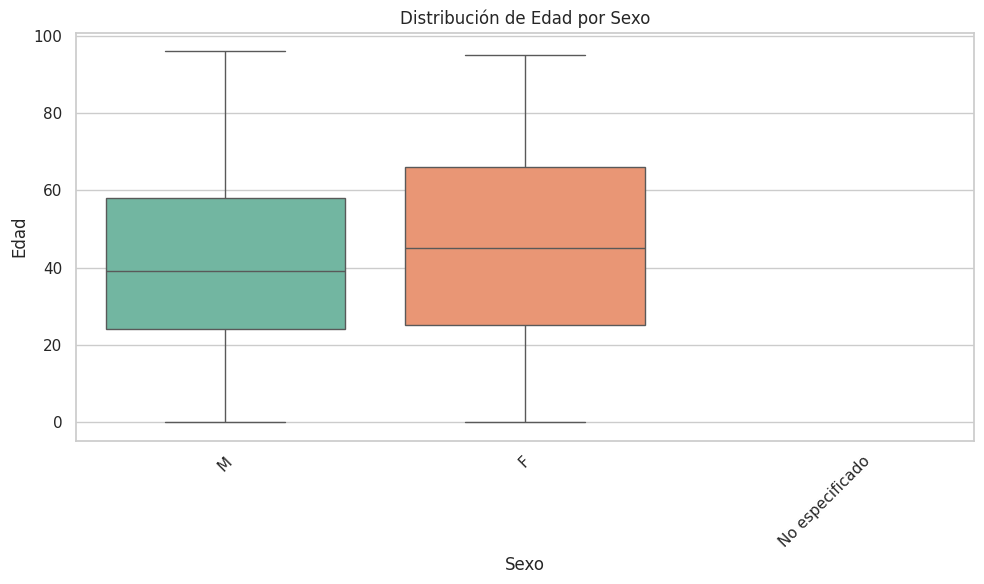

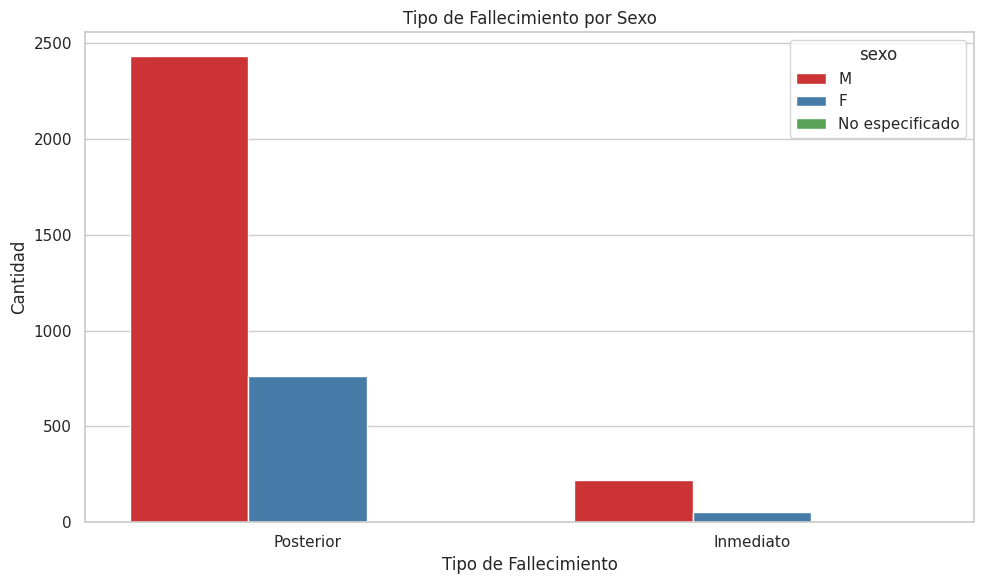

<ipython-input-28-e33a567e0457>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='rol', y='edad', palette='pastel')


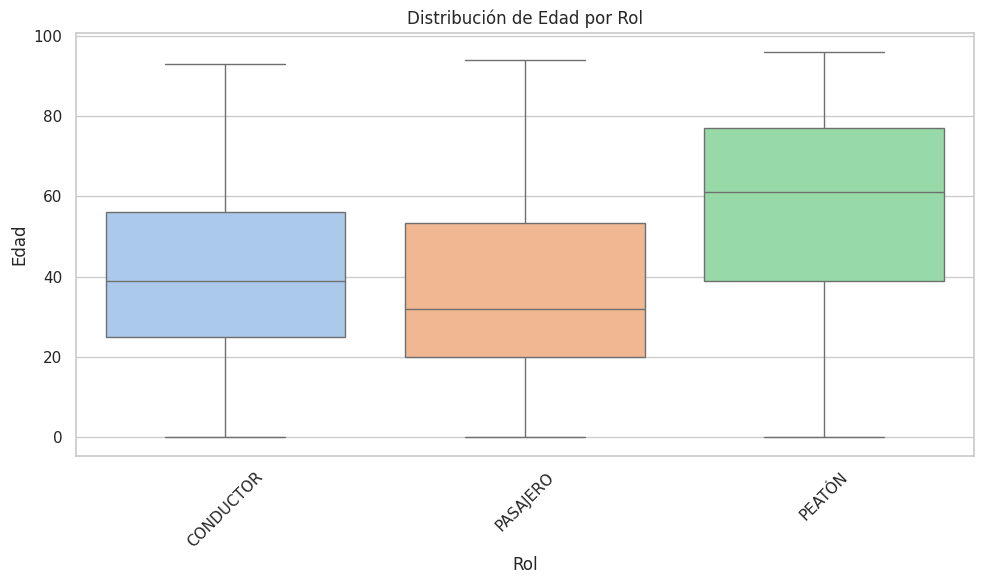

<ipython-input-28-e33a567e0457>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='tipo de siniestro', y='edad', palette='Spectral')


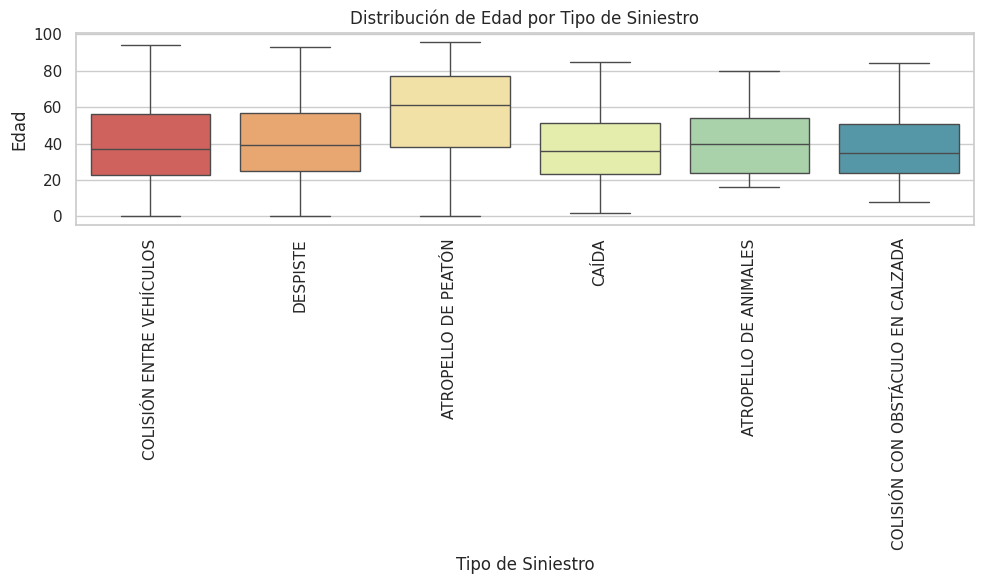

In [28]:
# --- 5. Análisis Demográfico y de Severidad ---

# Boxplot: Edad por Sexo
plt.figure()
sns.boxplot(data=df, x='sexo', y='edad', palette='Set2')
plt.title('Distribución de Edad por Sexo')
plt.xlabel('Sexo')  # Título eje X con mayúscula
plt.ylabel('Edad')  # Título eje Y con mayúscula
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tipo de Fallecimiento: Inmediato vs Posterior
df['tipo fallecimiento'] = np.where(df['fallecidos a los dias'] == 0, 'Inmediato', 'Posterior')


plt.figure()
sns.countplot(data=df, x='tipo fallecimiento', hue='sexo', palette='Set1')
plt.title('Tipo de Fallecimiento por Sexo')
plt.xlabel('Tipo de Fallecimiento')  # Título eje X con mayúscula
plt.ylabel('Cantidad')  # Título eje Y con mayúscula
plt.tight_layout()
plt.show()

# Boxplot: Edad por Rol
plt.figure()
sns.boxplot(data=df, x='rol', y='edad', palette='pastel')
plt.title('Distribución de Edad por Rol')
plt.xlabel('Rol')  # Título eje X con mayúscula
plt.ylabel('Edad')  # Título eje Y con mayúscula
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot: Edad por Tipo de Siniestro
plt.figure()
sns.boxplot(data=df, x='tipo de siniestro', y='edad', palette='Spectral')
plt.title('Distribución de Edad por Tipo de Siniestro')
plt.xlabel('Tipo de Siniestro')  # Título eje X con mayúscula
plt.ylabel('Edad')  # Título eje Y con mayúscula
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



**6. Clustering (K-Prototypes)**

In [29]:
cols_cat = cat_cols
cols_num = ['hora','edad','fallecidos a los dias']
df[cols_num] = df[cols_num].apply(lambda x: x.fillna(x.median()))
mat = df[cols_cat + cols_num].to_numpy()
cat_pos = list(range(len(cols_cat)))
kproto = KPrototypes(n_clusters=4, init='Cao', random_state=42)
df['cluster'] = kproto.fit_predict(mat, categorical=cat_pos)

for idx, c in enumerate(range(4)):
    grp = df[df['cluster']==c]
    print(f"Cluster {c}: {len(grp)} → Vehículo: {grp['vehiculo'].mode()[0]}, Siniestro: {grp['tipo de siniestro'].mode()[0]}")


Cluster 0: 558 → Vehículo: PEATÓN, Siniestro: ATROPELLO DE PEATÓN
Cluster 1: 919 → Vehículo: MOTO, Siniestro: COLISIÓN ENTRE VEHÍCULOS
Cluster 2: 1168 → Vehículo: MOTO, Siniestro: COLISIÓN ENTRE VEHÍCULOS
Cluster 3: 832 → Vehículo: MOTO, Siniestro: COLISIÓN ENTRE VEHÍCULOS


**7. Predicción para 2021 con RandomForest**


In [30]:
from sklearn.ensemble import RandomForestRegressor

# Preparación datos para regresión no lineal
agg = df.groupby('año').size().reset_index(name='count')
agg = agg[agg['año'] <= 2019]

X_year = agg[['año']]
y_year = agg['count']

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_year, y_year)

# Predicción para 2021
pred_2021_rf = rf_model.predict([[2021]])[0]
print(f"Predicción Random Forest para 2021: {pred_2021_rf:.0f} fallecidos")

Predicción Random Forest para 2021: 459 fallecidos


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


**7.1 Comparación con dato real**



In [31]:
# Accuracy (comparado con dato real si lo tenés, por ejemplo 434)
real_2021 = 434
accuracy_rf = (1 - abs(pred_2021_rf - real_2021) / real_2021) * 100
print(f"Accuracy vs dato real (434): {accuracy_rf:.2f}%")

Accuracy vs dato real (434): 94.21%


**7.2 Accuracy del modelo sin conocer el dato real con un umbral de error**

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predicciones sobre los mismos datos usados para entrenamiento (puede usarse para evaluación básica)
y_pred_rf = rf_model.predict(X_year)

mae = mean_absolute_error(y_year, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_year, y_pred_rf))
r2 = r2_score(y_year, y_pred_rf)

print(f"Evaluación del modelo Random Forest (2013–2019):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

accuracy_margin = 30
accuracy = (abs(y_pred_rf - y_year) <= accuracy_margin).mean() * 100
print(f"Accuracy ±{accuracy_margin} muertos: {accuracy:.2f}%")

Evaluación del modelo Random Forest (2013–2019):
MAE: 14.76
RMSE: 18.61
R²: 0.85
Accuracy ±30 muertos: 85.71%


8. Visualizaciones

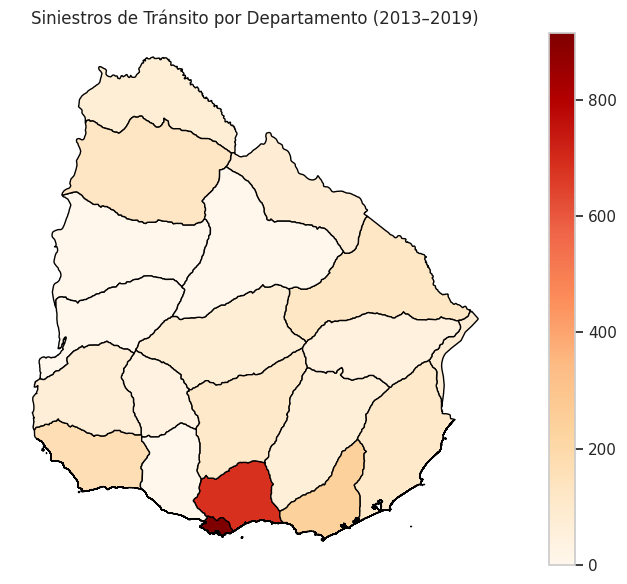

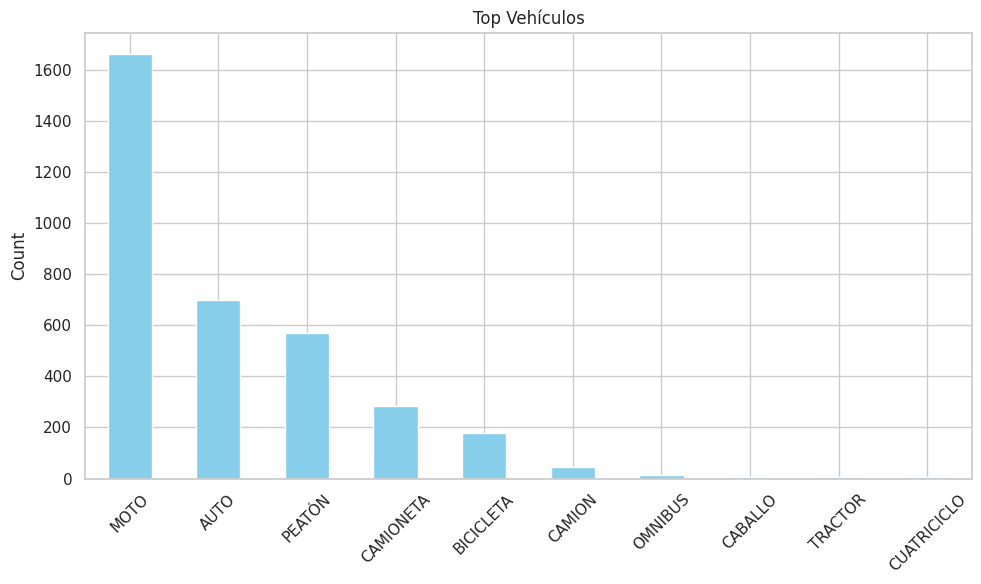

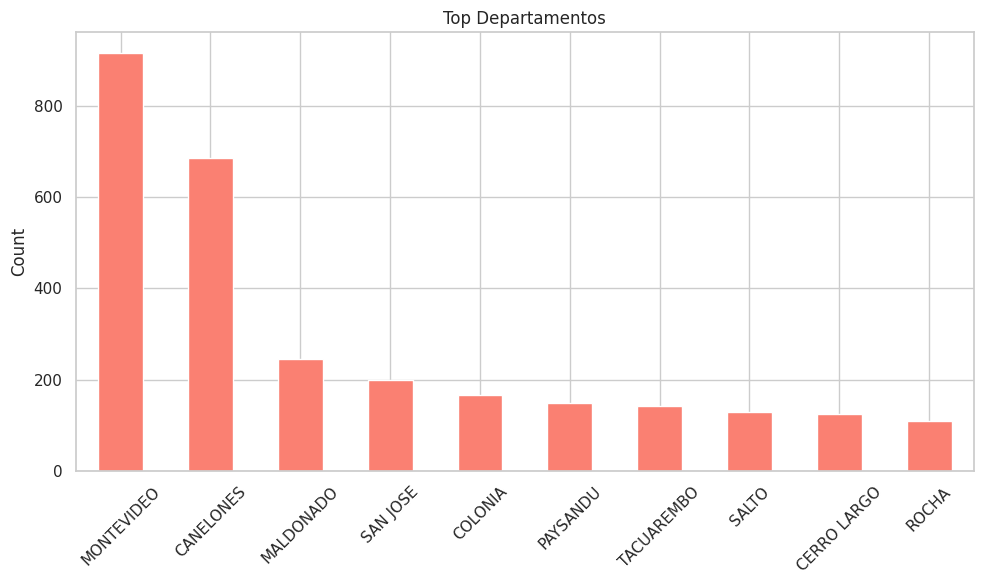

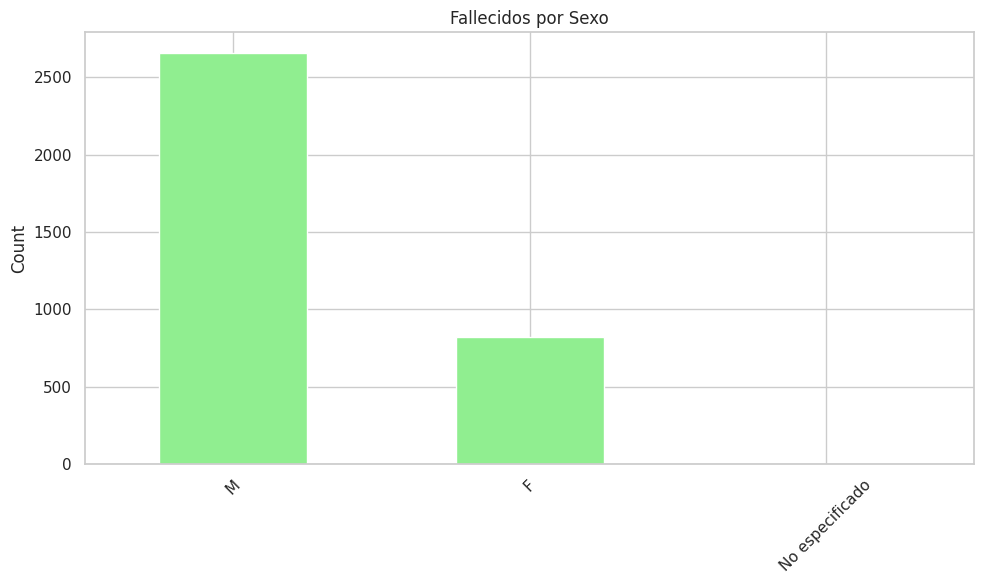

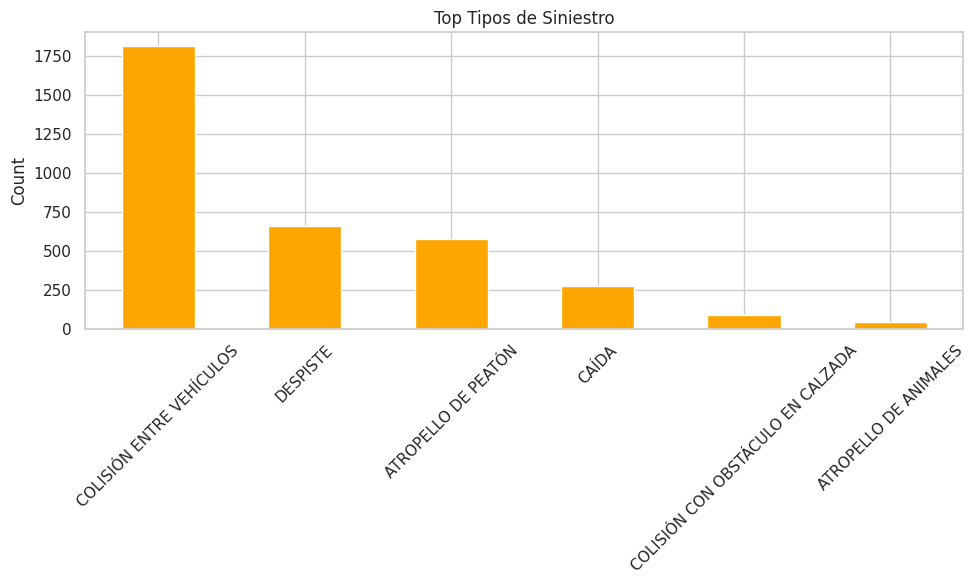

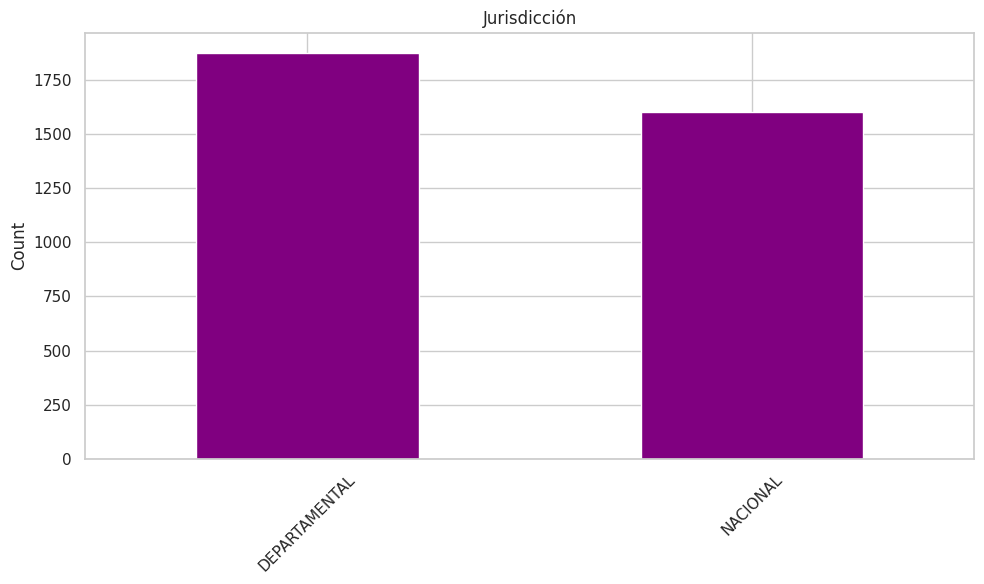

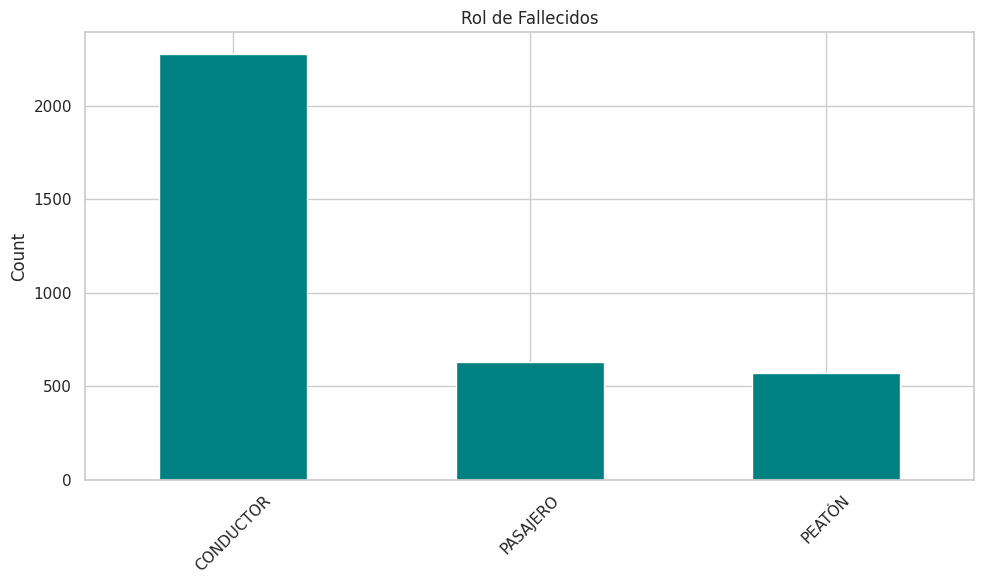

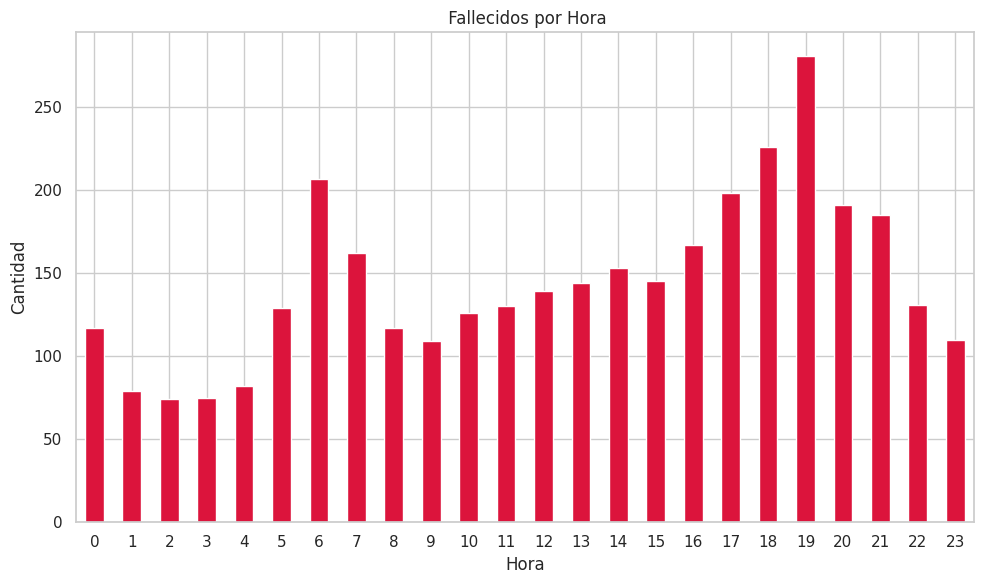

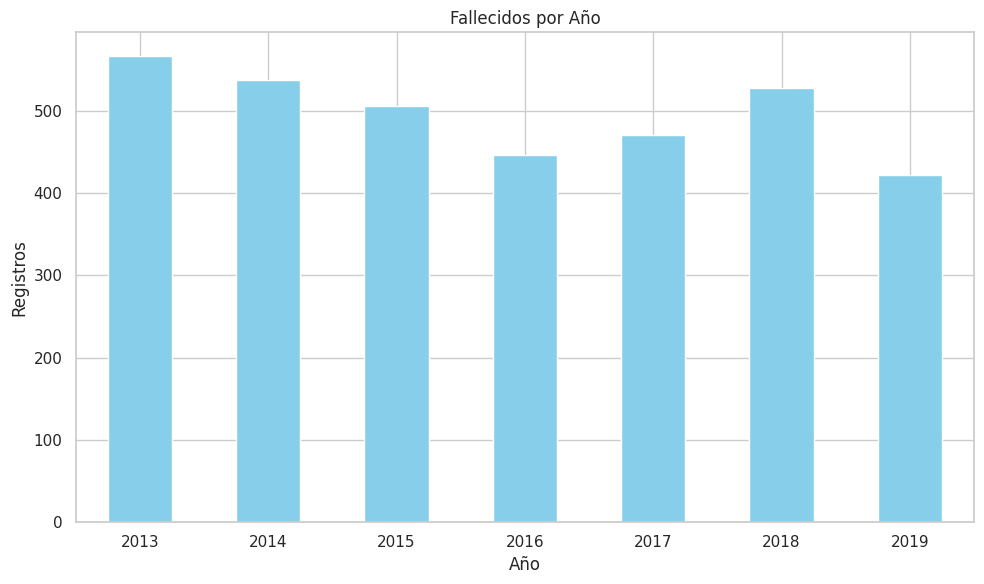

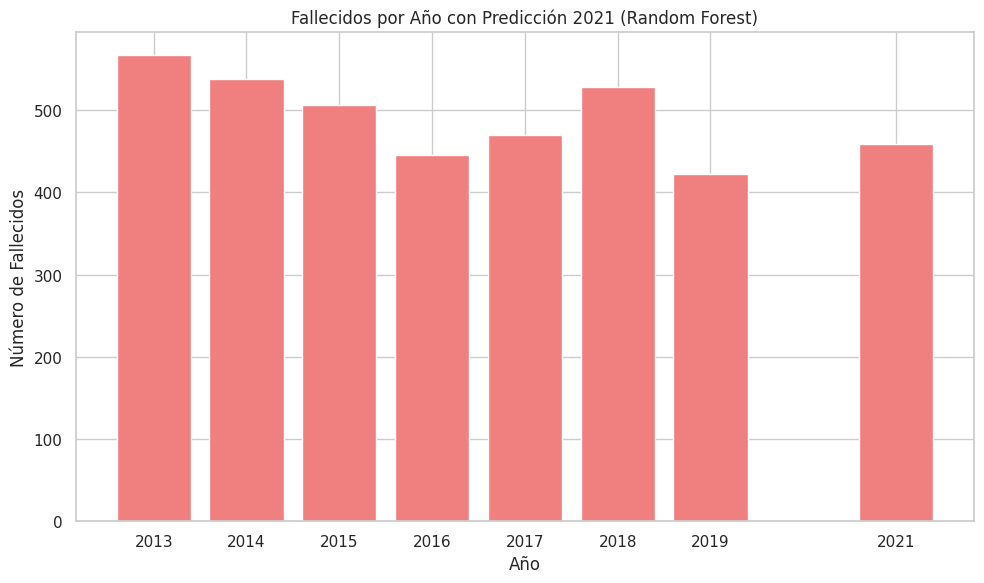

In [33]:
colors = ['skyblue','salmon','lightgreen','orange','purple','teal','crimson']

def plot_top(series, title, top_n=10, color='blue'):
    data = series.value_counts().head(top_n)
    plt.figure()
    data.plot.bar(color=color)
    plt.title(title)
    plt.xlabel('')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Mapa Departamentos
mapa.plot(column='siniestros', cmap='OrRd', legend=True, edgecolor='black')
plt.title('Siniestros de Tránsito por Departamento (2013–2019)')
plt.axis('off')
plt.tight_layout()
plt.show()


# Top variables categóricas
plot_top(df['vehiculo'], 'Top Vehículos', 10, color=colors[0])
plot_top(df['departamento'], 'Top Departamentos', 10, color=colors[1])
plot_top(df['sexo'], 'Fallecidos por Sexo', None, color=colors[2])
plot_top(df['tipo de siniestro'], 'Top Tipos de Siniestro', 10, color=colors[3])
plot_top(df['jurisdiccion'], 'Jurisdicción', None, color=colors[4])
plot_top(df['rol'], 'Rol de Fallecidos', None, color=colors[5])

# Accidentes por Hora
gg = df[df['hora'].between(0,23)]['hora'].value_counts().sort_index()
plt.figure()
gg.plot.bar(color=colors[6])
plt.title(' Fallecidos por Hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Fallecidos por Año
años = list(range(2013,2020))
acc_anual = df[df['año'].isin(años)].groupby('año').size().reindex(años, fill_value=0)
plt.figure()
acc_anual.plot.bar(color=colors[0])
plt.title('Fallecidos por Año')
plt.xlabel('Año')
plt.ylabel('Registros')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Gráfico
agg_plot_rf = pd.concat([
    agg,
    pd.DataFrame({'año': [2021], 'count': [pred_2021_rf]})
], ignore_index=True)

plt.figure()
plt.bar(agg_plot_rf['año'], agg_plot_rf['count'], color='lightcoral')
plt.title('Fallecidos por Año con Predicción 2021 (Random Forest)')
plt.xlabel('Año')
plt.ylabel('Número de Fallecidos')
plt.xticks(agg_plot_rf['año'])
plt.tight_layout()
plt.show()
